In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder , StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix


In [2]:
Appointment_data = pd.read_csv('Medical_Appointments_Data.csv') 

# Explore

In [3]:
Appointment_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
Appointment_data.shape

(110527, 14)

In [5]:
Appointment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
Appointment_data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [7]:
Appointment_data.isna().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [8]:
Appointment_data.duplicated().sum()

0

# Cleanning

In [9]:
#conver ScheduledDay	AppointmentDay to datetime 
Appointment_data['ScheduledDay'] = pd.to_datetime(Appointment_data['ScheduledDay']).dt.date.astype('datetime64[ns]')
Appointment_data['AppointmentDay'] = pd.to_datetime(Appointment_data['AppointmentDay']).dt.date.astype('datetime64[ns]')

In [10]:
Appointment_data.rename(columns = {'No-show':'No_show'} ,inplace=True)

In [11]:
Appointment_data['duration'] = (Appointment_data['AppointmentDay'] - Appointment_data['ScheduledDay']).dt.days

0-monday
.
.
.

6-sunday

In [12]:
Appointment_data['ScheduledDay'] = Appointment_data['ScheduledDay'].dt.dayofweek

In [13]:
Appointment_data['AppointmentDay'] = Appointment_data['AppointmentDay'].dt.dayofweek

In [14]:
Appointment_data['duration'] = Appointment_data['duration'].astype('int64')

In [15]:
(Appointment_data['No_show'][Appointment_data['duration']==0]).value_counts()/len(Appointment_data['No_show'])

No_show
No     0.332688
Yes    0.016213
Name: count, dtype: float64

In [26]:
Appointment_data.sample(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,duration
75380,5.792423e+13,5656807,F,2,2,48,NOVA PALESTINA,0,1,0,0,0,0,No,0
96984,4.363816e+13,5521810,M,1,0,61,SANTOS DUMONT,0,1,1,0,0,0,No,69


In [27]:
Appointment_data[Appointment_data['Age']<0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,duration
99832,4.659432e+14,5775010,F,0,0,-1,ROMÃO,0,0,0,0,0,0,No,0


In [28]:
Appointment_data[Appointment_data['Age']<1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,duration
59,7.184428e+13,5638545,F,4,4,0,CONQUISTA,0,0,0,0,0,0,No,0
63,2.366233e+14,5628286,M,2,4,0,SÃO BENEDITO,0,0,0,0,0,0,No,2
64,1.885174e+14,5616082,M,0,4,0,ILHA DAS CAIEIRAS,0,0,0,0,0,1,No,4
65,2.718818e+14,5628321,M,2,4,0,CONQUISTA,0,0,0,0,0,0,No,2
67,8.647128e+13,5639264,F,4,4,0,NOVA PALESTINA,0,0,0,0,0,0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110345,1.473952e+14,5702537,F,0,2,0,RESISTÊNCIA,0,0,0,0,0,0,No,16
110346,5.577525e+12,5777724,M,0,2,0,RESISTÊNCIA,0,0,0,0,0,0,No,2
110454,6.142460e+11,5772400,F,4,4,0,RESISTÊNCIA,0,0,0,0,0,0,No,0
110460,4.321846e+13,5769545,F,4,4,0,RESISTÊNCIA,0,0,0,0,0,0,No,0


In [29]:
Appointment_data.loc[Appointment_data['Age'] < 1, 'Age'] = 1

In [30]:
Appointment_data[Appointment_data['Age']>110]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,duration
63912,3.196321e+13,5700278,F,0,3,115,ANDORINHAS,0,0,0,0,1,0,Yes,3
63915,3.196321e+13,5700279,F,0,3,115,ANDORINHAS,0,0,0,0,1,0,Yes,3
68127,3.196321e+13,5562812,F,4,0,115,ANDORINHAS,0,0,0,0,1,0,Yes,38
76284,3.196321e+13,5744037,F,0,0,115,ANDORINHAS,0,0,0,0,1,0,No,0
97666,7.482346e+14,5717451,F,3,4,115,SÃO JOSÉ,0,1,0,0,0,1,No,15


# Analysis

In [31]:
Appointment_data['Gender'].value_counts()

Gender
F    71840
M    38687
Name: count, dtype: int64

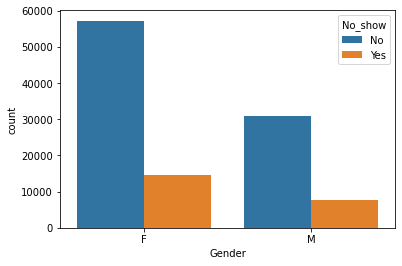

In [32]:
sns.countplot(data = Appointment_data , x ='Gender', hue='No_show')
plt.show()

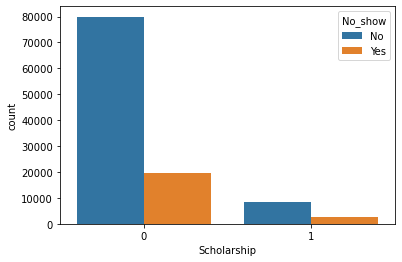

In [33]:
sns.countplot(data = Appointment_data , x ='Scholarship', hue='No_show')
plt.show()

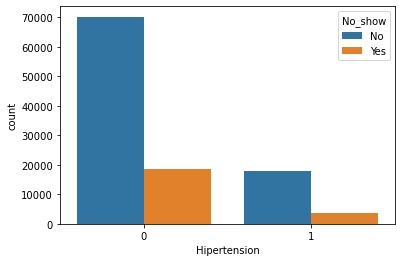

In [34]:
sns.countplot(data = Appointment_data , x ='Hipertension', hue='No_show')
plt.show()

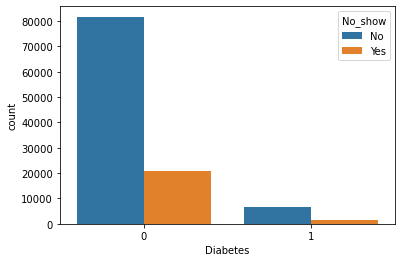

In [35]:
sns.countplot(data = Appointment_data , x ='Diabetes', hue='No_show')
plt.show()

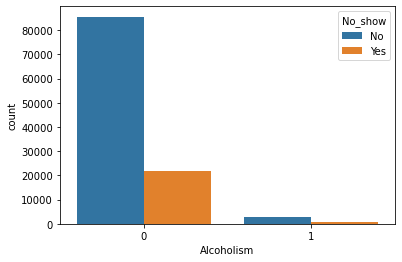

In [36]:
sns.countplot(data = Appointment_data , x ='Alcoholism', hue='No_show')
plt.show()

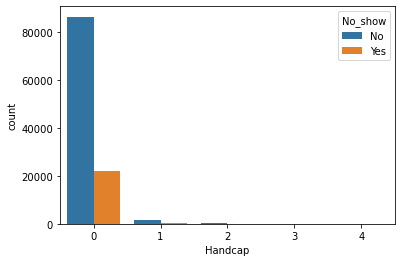

In [37]:
sns.countplot(data = Appointment_data , x ='Handcap', hue='No_show')
plt.show()

In [38]:
Appointment_data['Handcap'].value_counts()

Handcap
0    108286
1      2042
2       183
3        13
4         3
Name: count, dtype: int64

In [39]:
Appointment_data['SMS_received'].value_counts()

SMS_received
0    75045
1    35482
Name: count, dtype: int64

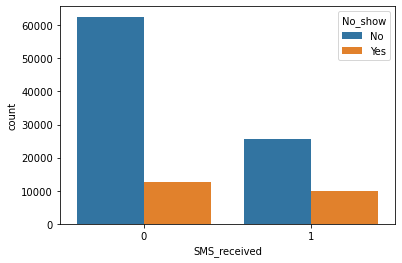

In [40]:
sns.countplot(data = Appointment_data , x ='SMS_received', hue='No_show')
plt.show()

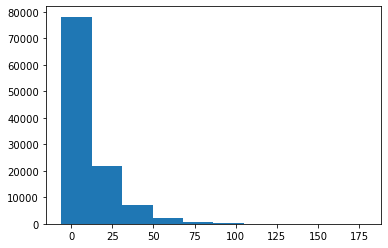

In [41]:
plt.hist(Appointment_data['duration'])
plt.show()

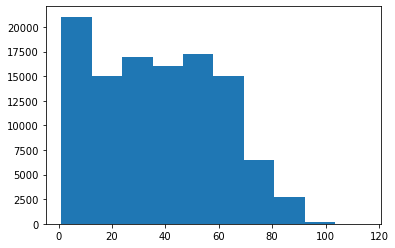

In [42]:
plt.hist(Appointment_data['Age'] )
plt.show()

In [43]:
print(Appointment_data['Neighbourhood'].unique())

['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'ILHA DO PRÍNCIPE' 'ROMÃO' 'COMDUSA'


In [44]:
Appointment_data['Neighbourhood'].value_counts()

Neighbourhood
JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: count, Length: 81, dtype: int64

In [45]:
counts = Appointment_data['No_show'].value_counts()
counts

No_show
No     88208
Yes    22319
Name: count, dtype: int64

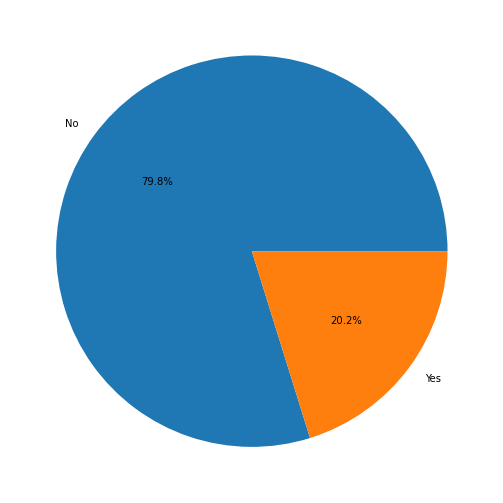

In [46]:
plt.figure(figsize=(15,9))
plt.pie(counts , labels=counts.index , autopct='%1.1f%%')
plt.show()

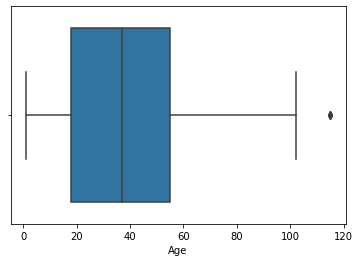

In [47]:
sns.boxplot(data = Appointment_data ,x ='Age')
plt.show()

In [48]:
#No Schedule in day 6(sunday)
scheduledDay_counts = Appointment_data['ScheduledDay'].value_counts()
scheduledDay_counts

ScheduledDay
1    26168
2    24262
0    23085
4    18915
3    18073
5       24
Name: count, dtype: int64

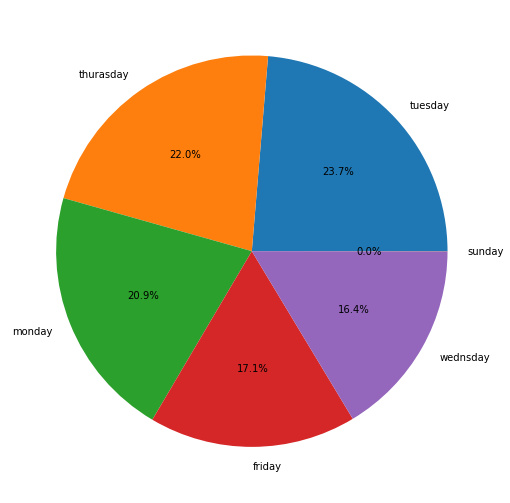

In [49]:
labels=['tuesday' , 'thurasday' , 'monday' ,'friday' ,'wednsday','sunday']
plt.figure(figsize=(15,9))
plt.pie(scheduledDay_counts ,
        labels=labels ,autopct='%1.1f%%')
plt.show()

In [50]:
#No Appointment in day 6(sunday)
#Appointment saturday is little 
appointmentDay_counts = Appointment_data['AppointmentDay'].value_counts()
appointmentDay_counts

AppointmentDay
2    25867
1    25640
0    22715
4    19019
3    17247
5       39
Name: count, dtype: int64

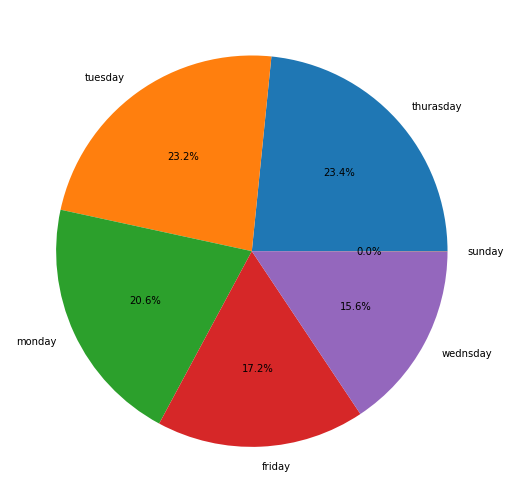

In [51]:
labels=[ 'thurasday' ,'tuesday' , 'monday' ,'friday' ,'wednsday','sunday']
plt.figure(figsize=(15,9))
plt.pie(appointmentDay_counts ,
        labels=labels ,autopct='%1.1f%%')
plt.show()

In [52]:
Appointment_data['duration'].max()

179

0 corresponds to the count of "No" (appointments that were not missed), and
1 corresponds to the count of "Yes" (appointments that were missed).

In [53]:
Appointment_data['No_show'].value_counts()/len(Appointment_data)

No_show
No     0.798067
Yes    0.201933
Name: count, dtype: float64

In [55]:
#percentage of missed and not missed appointments out of the total where duration == 0
(Appointment_data['No_show'][Appointment_data['duration']==0]).value_counts()/len(Appointment_data['No_show'])

No_show
No     0.332688
Yes    0.016213
Name: count, dtype: float64

In [56]:
(Appointment_data['No_show'][Appointment_data['duration']==1]).value_counts()/len(Appointment_data['No_show'])

No_show
No     0.037095
Yes    0.010070
Name: count, dtype: float64

In [57]:
(Appointment_data['No_show'][Appointment_data['duration']==2]).value_counts()/len(Appointment_data['No_show'])

No_show
No     0.046351
Yes    0.014494
Name: count, dtype: float64

In [58]:
(Appointment_data['No_show'][Appointment_data['duration']==3]).value_counts()

No_show
No     2093
Yes     644
Name: count, dtype: int64

In [59]:
duration_grouped = Appointment_data.groupby('duration')['No_show'].value_counts(normalize=True).unstack()[2:]
duration_grouped

No_show,No,Yes
duration,,
0,0.953531,0.046469
1,0.786495,0.213505
2,0.761784,0.238216
3,0.764706,0.235294
4,0.767297,0.232703
...,...,...
155,0.400000,0.600000
162,0.818182,0.181818
169,0.875000,0.125000


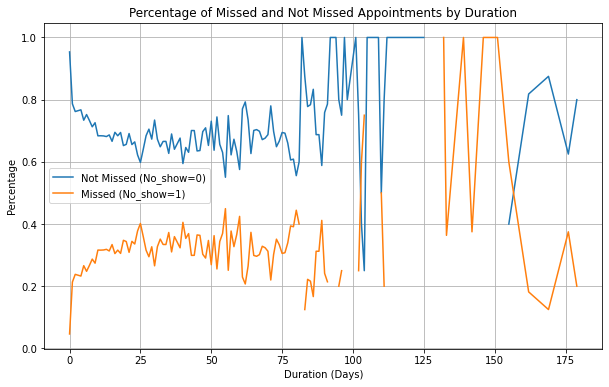

In [60]:
duration_index = duration_grouped.index.to_numpy()

# Plot the percentages for missed (No_show=1) and not missed (No_show=0) appointments
plt.figure(figsize=(10, 6))

# Plot the 'Not Missed' appointments (No_show=0)
plt.plot(duration_index, duration_grouped['No'].to_numpy(), label='Not Missed (No_show=0)')

# Plot the 'Missed' appointments (No_show=1)
plt.plot(duration_index, duration_grouped['Yes'].to_numpy(), label='Missed (No_show=1)')

# Customize the plot
plt.title('Percentage of Missed and Not Missed Appointments by Duration')
plt.xlabel('Duration (Days)')
plt.ylabel('Percentage')
plt.legend()

plt.grid(True)
plt.show()


people who's days difference <3 don't receive any message

In [61]:
Appointment_data[(Appointment_data['duration']<3) & (Appointment_data['SMS_received'] ==1)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,duration


# preprocessing

In [62]:
Appointment_data['No_show'] = Appointment_data['No_show'].map({'Yes':1 , 'No':0})

In [63]:
Appointment_data['Gender'] = Appointment_data['Gender'].map({'F':1 , 'M':0})

In [64]:
lb = LabelEncoder()
Appointment_data['Neighbourhood'] = lb.fit_transform(Appointment_data['Neighbourhood'])

In [65]:
Appointment_data.sample()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,duration
76302,7.826923e+13,5651820,1,1,0,51,1,0,0,0,0,0,0,0,6


<AxesSubplot:>

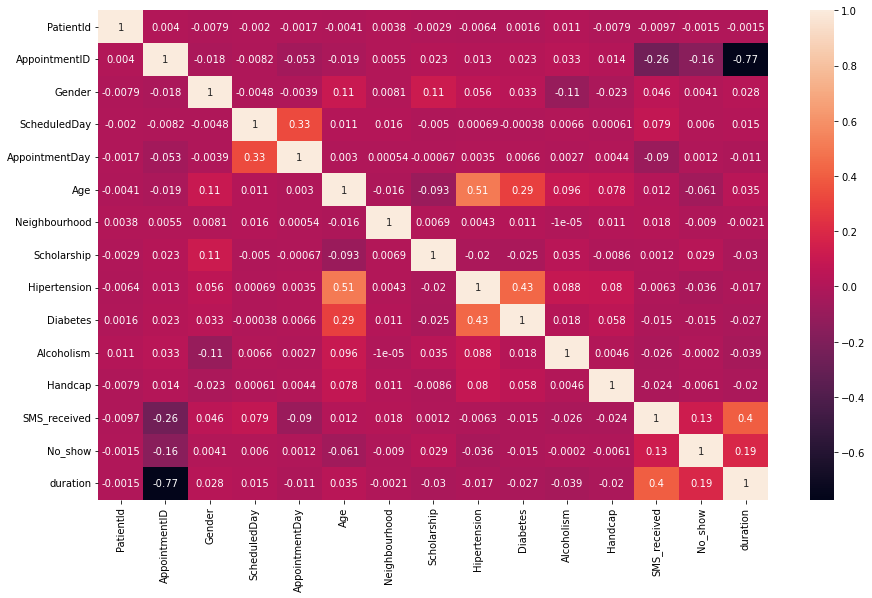

In [66]:
plt.figure(figsize=(15,9))
sns.heatmap(Appointment_data.corr() , annot=True)

In [67]:
X = Appointment_data.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay' , 'AppointmentDay' , 'No_show'])
y = Appointment_data['No_show']

In [68]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
smote = SMOTE()
X_res , y_res = smote.fit_resample(X_scaled,y)

In [70]:
X_train , X_test , y_train , y_test = train_test_split(X_res, y_res , random_state=42)

# xgboost

In [84]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    learning_rate=0.9,
    max_depth=10,
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83     22010
           1       0.83      0.83      0.83     22094

    accuracy                           0.83     44104
   macro avg       0.83      0.83      0.83     44104
weighted avg       0.83      0.83      0.83     44104



# RandomForestClassifier

In [71]:
RF = RandomForestClassifier()

In [72]:
RF.fit(X_train , y_train)

RandomForestClassifier()

In [73]:
y_pred = RF.predict(X_test)
print(classification_report(y_pred , y_test))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     21923
           1       0.84      0.84      0.84     22181

    accuracy                           0.84     44104
   macro avg       0.84      0.84      0.84     44104
weighted avg       0.84      0.84      0.84     44104

